In [1]:
import geopandas as gpd
from tqdm import tqdm
import pandas as pd
import os
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans, AgglomerativeClustering
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import matplotlib
import matplotlib.patheffects as pe
import math
import hdbscan
from sklearn.decomposition import PCA
from sklearn.model_selection import ParameterGrid
from matplotlib.colors import LinearSegmentedColormap
import scipy
import statsmodels.api as sm
import contextily as cx

In [2]:
output_path = './Multi_F_Results_NWFim_Queen'

Import results files that has Bivaraite Moran's I. 

In [3]:
state_lookup = pd.read_csv('./census_geometry/state_lookup.csv')

mi = gpd.GeoDataFrame()
for i in range(0, 18):

    temp_path = os.path.join(output_path, f'N_{i}', f'Multi_F_mi.geojson')
    if os.path.exists(temp_path):
        temp_ = gpd.read_file(temp_path)
        temp_['iter'] = i
        mi = pd.concat([mi, temp_], ignore_index=True)
mi = mi.fillna(0)
mi['STATE'] = mi.apply(lambda x:x['ID'][0:2], axis=1)
mi = mi.merge(state_lookup, left_on='STATE', right_on='Abbr', how='left')

jeff = pd.read_csv('./archive/dam_hazard_potential_classification.csv')
mi = mi.merge(jeff[['ID', 'Risk']], on='ID')

mi

,ID,LAT,LON,NAME,LIBRARY_ID,LIBRARY_TYPE,MH_F,IH_F,TAS_F,SS_F,...,pval_GROUPQ,geometry,iter,STATE,Name,Abbr,FIPS,ContiguousUS,Region,Risk
0,CA10114,36.416309,-119.003224,TERMINUS DAM,199,dam_study,True,False,True,True,...,2.776156e-01,POINT (-119.00322 36.41631),0,CA,California,CA,6,1,Pacific,Low (4)
1,CA10113,36.060671,-118.919340,Richard L. Schafer Dam,98,dam_study,True,False,True,True,...,0.000000e+00,POINT (-118.91934 36.06067),0,CA,California,CA,6,1,Pacific,Moderate (3)
2,NY00468,42.733294,-77.907232,MOUNT MORRIS DAM,316,dam_study,True,False,True,True,...,5.551115e-15,POINT (-77.90723 42.73329),0,NY,New York,NY,36,1,MiddleAtlantic,Low (4)
3,CA10109,38.151041,-120.813699,NEW HOGAN DAM,297,dam_study,True,False,True,True,...,5.691836e-12,POINT (-120.81370 38.15104),0,CA,California,CA,6,1,Pacific,Moderate (3)
4,CA10104,37.906801,-120.934059,FARMINGTON DAM,260,dam_study,True,False,True,True,...,0.000000e+00,POINT (-120.93406 37.90680),0,CA,California,CA,6,1,Pacific,Moderate (3)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
340,MN00574,46.217141,-96.179236,ORWELL DAM,6188,dam_study,True,True,True,True,...,1.628310e-05,POINT (-96.17924 46.21714),16,MN,Minnesota,MN,27,1,WestNorthCentral,Low (4)
341,IL00117,38.037328,-88.961679,REND DAM,6106,dam_study,True,True,True,True,...,2.712650e-05,POINT (-88.96168 38.03733),16,IL,Illinois,IL,17,1,EastNorthCentral,Low (4)
342,OK10318,36.549055,-99.560571,FORT SUPPLY DAM,4203,dam_study,True,False,True,True,...,3.695257e-39,POINT (-99.56057 36.54905),16,OK,Oklahoma,OK,40,1,WestSouthCentral,Moderate (3)
343,MS01494,33.821629,-89.772394,GRENADA DAM,5646,dam_study,True,True,True,True,...,7.902761e-03,POINT (-89.77239 33.82163),16,MS,Mississippi,MS,28,1,EastSouthCentral,Low (4)


In [4]:
dams = pd.read_csv('./nation.csv', header=1)
dams = dams[['Federal ID', 'Primary Purpose', 'Primary Dam Type', 'Structural Height (Ft)', 
             'NID Height Category', 'Year Completed','Year Completed Category', 'Max Storage (Acre-Ft)',
             'Normal Storage (Acre-Ft)', 'Hazard Potential Classification'
            ]]
dams

/var/folders/dv/bcrkszqj0634wz_17m9xw0qr0000gn/T/ipykernel_57790/4128225669.py:1: DtypeWarning: Columns (75) have mixed types. Specify dtype option on import or set low_memory=False.
  dams = pd.read_csv('./nation.csv', header=1)


,Federal ID,Primary Purpose,Primary Dam Type,Structural Height (Ft),NID Height Category,Year Completed,Year Completed Category,Max Storage (Acre-Ft),Normal Storage (Acre-Ft),Hazard Potential Classification
0,KY00728,Other,Earth,NaN,Less than 25 feet,1974.0,1970-1979,86.8,26.6,Low
1,ND01160,Other,NaN,NaN,25-50 feet,NaN,Undetermined,682.6,NaN,Low
2,OK20994,Recreation,Earth,18.0,Less than 25 feet,1939.0,1930-1939,50.0,25.0,Low
3,OK20998,Recreation,Earth,15.0,Less than 25 feet,1940.0,1940-1949,50.0,25.0,Low
4,IL50526,Recreation,Rockfill,NaN,Less than 25 feet,1975.0,1970-1979,394.0,180.0,Low
...,...,...,...,...,...,...,...,...,...,...
91752,WV08902,Flood Risk Reduction,Concrete,165.0,Greater than 100 feet,1947.0,1940-1949,631000.0,38350.0,High
91753,OR00012,Flood Risk Reduction,Rockfill,126.0,Greater than 100 feet,1967.0,1960-1969,61000.0,56000.0,High
91754,IL00007,Navigation,Concrete,65.0,51-100 feet,1933.0,1930-1939,25000.0,0.0,High
91755,TX00008,Flood Risk Reduction,Earth,135.0,Greater than 100 feet,1955.0,1950-1959,1804300.0,618400.0,High


In [5]:
mi_dams = mi.merge(dams, left_on='ID', right_on='Federal ID')
mi_dams

,ID,LAT,LON,NAME,LIBRARY_ID,LIBRARY_TYPE,MH_F,IH_F,TAS_F,SS_F,...,Federal ID,Primary Purpose,Primary Dam Type,Structural Height (Ft),NID Height Category,Year Completed,Year Completed Category,Max Storage (Acre-Ft),Normal Storage (Acre-Ft),Hazard Potential Classification
0,CA10114,36.416309,-119.003224,TERMINUS DAM,199,dam_study,True,False,True,True,...,CA10114,Flood Risk Reduction,Earth,255.0,Greater than 100 feet,1962.0,1960-1969,235205.0,113431.0,High
1,CA10113,36.060671,-118.919340,Richard L. Schafer Dam,98,dam_study,True,False,True,True,...,CA10113,Flood Risk Reduction,Earth,145.0,Greater than 100 feet,1961.0,1960-1969,230000.0,65473.0,High
2,NY00468,42.733294,-77.907232,MOUNT MORRIS DAM,316,dam_study,True,False,True,True,...,NY00468,Flood Risk Reduction,Concrete,245.0,Greater than 100 feet,1952.0,1950-1959,408000.0,4660.0,High
3,CA10109,38.151041,-120.813699,NEW HOGAN DAM,297,dam_study,True,False,True,True,...,CA10109,Flood Risk Reduction,Rockfill,210.0,Greater than 100 feet,1963.0,1960-1969,348598.0,217410.0,High
4,CA10104,37.906801,-120.934059,FARMINGTON DAM,260,dam_study,True,False,True,True,...,CA10104,Flood Risk Reduction,Earth,58.0,51-100 feet,1951.0,1950-1959,119314.0,6623.0,High
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
340,MN00574,46.217141,-96.179236,ORWELL DAM,6188,dam_study,True,True,True,True,...,MN00574,Flood Risk Reduction,Earth,60.0,51-100 feet,1953.0,1950-1959,20600.0,8050.0,High
341,IL00117,38.037328,-88.961679,REND DAM,6106,dam_study,True,True,True,True,...,IL00117,Flood Risk Reduction,Concrete,54.0,51-100 feet,1971.0,1970-1979,607910.0,184675.0,High
342,OK10318,36.549055,-99.560571,FORT SUPPLY DAM,4203,dam_study,True,False,True,True,...,OK10318,Flood Risk Reduction,Earth,85.0,51-100 feet,1942.0,1940-1949,100700.0,13900.0,High
343,MS01494,33.821629,-89.772394,GRENADA DAM,5646,dam_study,True,True,True,True,...,MS01494,Flood Risk Reduction,Earth,103.0,Greater than 100 feet,1954.0,1950-1959,2722100.0,85700.0,High


The name of the columns for Moran's I results

In [6]:
# str: single variable
# list: [[To be summed and set as numerator], demonimator]  
census_info = {
                "EP_POV150" : [['S1701_C01_040E'], 'S1701_C01_001E'],
                "EP_UNEMP"  : 'DP03_0009PE',
                "EP_HBURD"  : [['S2503_C01_028E', 'S2503_C01_032E', 'S2503_C01_036E', 'S2503_C01_040E'], 
                            'S2503_C01_001E'],
                "EP_NOHSDP" : 'S0601_C01_033E',
                "EP_UNINSUR" : 'S2701_C05_001E',
                "EP_AGE65" : 'S0101_C02_030E',
                "EP_AGE17" : [['B09001_001E'], 
                            'S0601_C01_001E'],
                "EP_DISABL" : 'DP02_0072PE',
                "EP_SNGPNT" : [['B11012_010E', 'B11012_015E'], 'DP02_0001E'],
                "EP_LIMENG" : [['B16005_007E', 'B16005_008E', 'B16005_012E', 'B16005_013E', 'B16005_017E', 'B16005_018E', 
                                'B16005_022E', 'B16005_023E', 'B16005_029E', 'B16005_030E', 'B16005_034E', 'B16005_035E',
                                'B16005_039E', 'B16005_040E', 'B16005_044E', 'B16005_045E'], 
                            'B16005_001E'],
                "EP_MINRTY" : [['DP05_0071E', 'DP05_0078E', 'DP05_0079E', 'DP05_0080E', 
                                'DP05_0081E', 'DP05_0082E', 'DP05_0083E'],
                            'S0601_C01_001E'],
                "EP_MUNIT" : [['DP04_0012E', 'DP04_0013E'], 
                            'DP04_0001E'],
                "EP_MOBILE" : 'DP04_0014PE',
                "EP_CROWD" : [['DP04_0078E', 'DP04_0079E'], 
                            'DP04_0002E'],
                "EP_NOVEH" : 'DP04_0058PE',
                "EP_GROUPQ": [['B26001_001E'], 
                            'S0601_C01_001E'],
}
plot_cols_mi = ['MI_' + col.split('_')[1] for col in census_info.keys()]
plot_cols_lm = ['LISA_' + col.split('_')[1] for col in census_info.keys()]

## Overall distribution of SVI variables

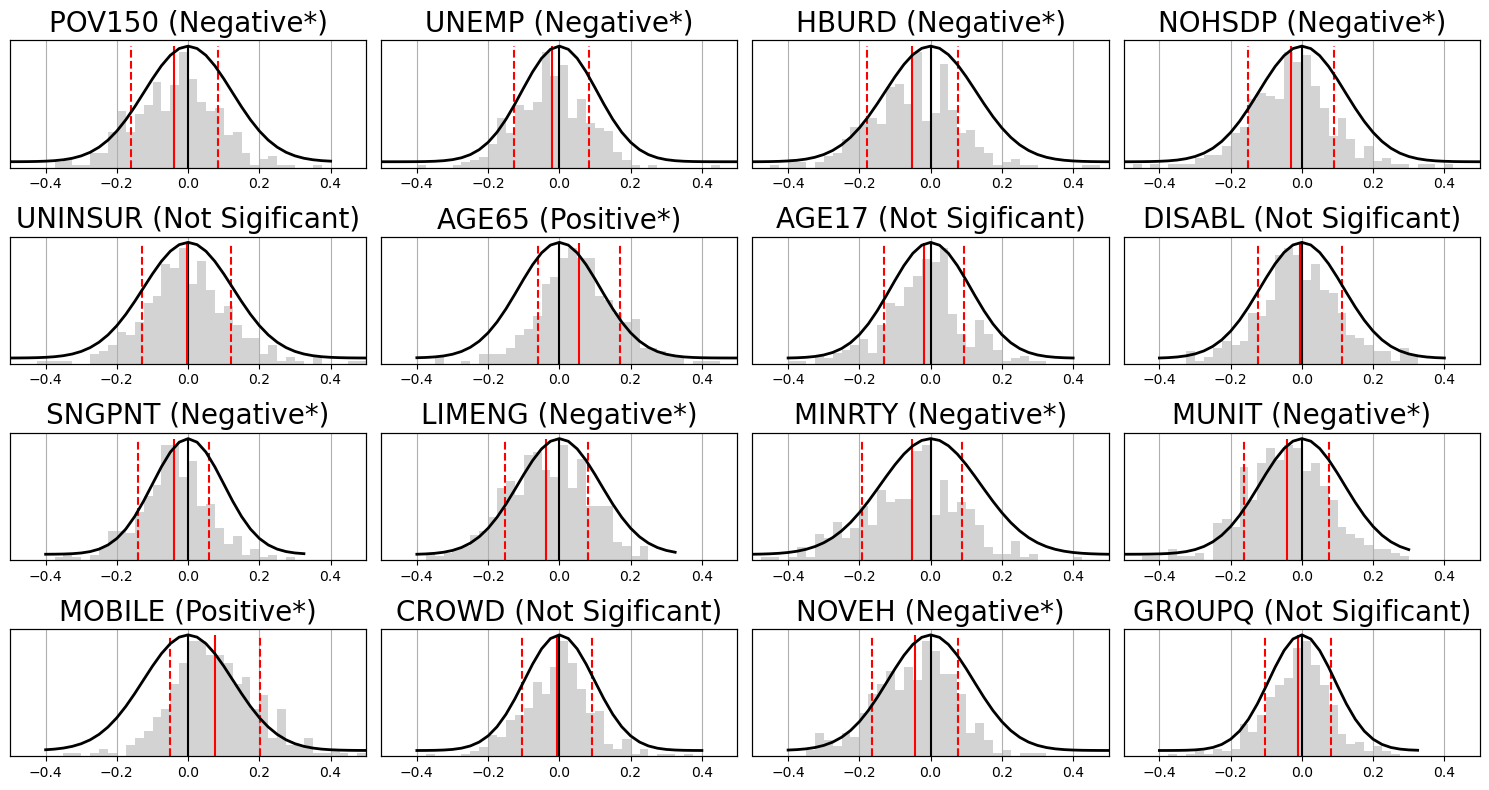

In [7]:
mi_ = mi[[col for col in mi.columns if col.startswith('MI')]]

for col in mi_.columns:
    mi_ = mi_.loc[pd.notna(mi_[col])]

ttest_df = pd.DataFrame(data={'var': [col for col in mi.columns if col.startswith('MI')]}, 
                        columns=['var', 'mean', 'std','coef', 'pval'])

# Conduct T-test
for col in plot_cols_mi:
    ttest_ = scipy.stats.ttest_1samp(mi_[col], popmean=0)
    ttest_df.loc[ttest_df['var'] == col, 'mean'] = mi_[col].mean()
    ttest_df.loc[ttest_df['var'] == col, 'std'] = mi_[col].std()
    ttest_df.loc[ttest_df['var'] == col, 'coef'] = ttest_[0]
    ttest_df.loc[ttest_df['var'] == col, 'pval'] = ttest_[1]

ttest_df['bonferroni'] = sm.stats.multipletests(ttest_df['pval'], 0.05, method='bonferroni')[0] # For Bonferroni Correction

fig, axes = plt.subplots(4, 4, figsize=(15,8))
ax = axes.reshape(-1)

binwidth = 0.025
n = 10
pvalue_list = [] # For Bonferroni Correction

# for idx, col in enumerate(plot_cols_mi):
for idx, row in ttest_df.iterrows():
    
    bins = np.arange(math.floor(min(mi_[row['var']]) * n) / n, math.ceil(max(mi_[row['var']]) * n) / n + binwidth, binwidth)
    
    mi_[row['var']].hist(ax=ax[idx], bins=bins, color='lightgrey')
    
    # Generate Normal Distribution with the mean of 0 and the same std. 
    ax2 = ax[idx].twinx()
    mu, sigma = 0, mi_[row['var']].std()
    s = np.random.default_rng().normal(loc=0.0, scale=sigma, size=10000)
    ax2.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) *
                 np.exp( - (bins - mu)**2 / (2 * sigma**2) ),
                 linewidth=2, color='black')

    ylim = ax[idx].get_ylim()[1]
    ax[idx].vlines(0, 0, ylim, color='black')
    ax[idx].vlines(mi_[row['var']].mean(), 0, ylim, color='red')
    ax[idx].vlines(mi_[row['var']].mean() + mi_[row['var']].std(), 0, ylim, color='red', linestyles='dashed')
    ax[idx].vlines(mi_[row['var']].mean() - mi_[row['var']].std(), 0, ylim, color='red', linestyles='dashed')

    if row['bonferroni'] == True:
        if row['mean'] > 0:
            label = 'Positive*'
        else:
            label = 'Negative*'
    else:
        label = 'Not Sigificant'
    
    ax[idx].set_title(label=f"{row['var'].split('_')[1]} ({label})", fontsize=20)
    ax[idx].set_xlim(-0.5, 0.5)
    ax[idx].get_yaxis().set_visible(False)
    ax2.get_yaxis().set_visible(False)
    
plt.tight_layout()
plt.show()

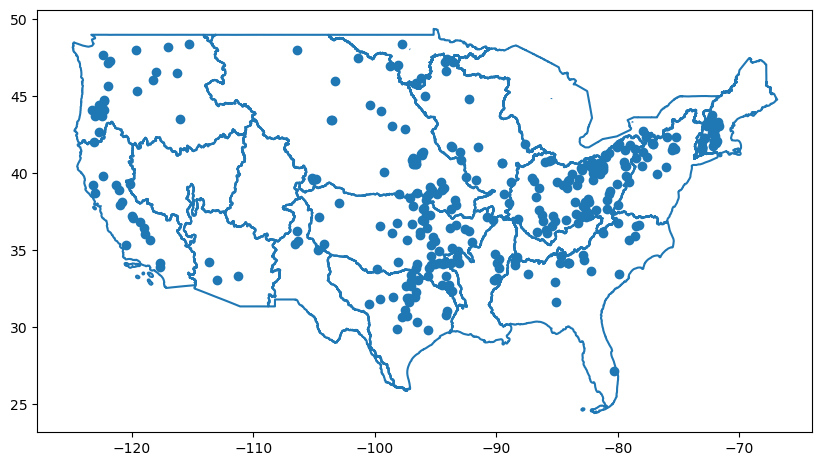

In [8]:
states = gpd.read_file('./census_geometry/tl_2022_us_state.shp')
states = states.merge(state_lookup, left_on='STUSPS', right_on='Abbr')
states = states.loc[states['ContiguousUS'] == 1]
states = states.to_crs(epsg=4326)

basins = gpd.read_file('./census_geometry/WBD_HU2.shp')
basins = basins.to_crs(epsg=4326)
basins = gpd.clip(basins, states)

for idx, row in basins.iterrows():
    mi_dams.loc[mi_dams['geometry'].within(row['geometry']), 'HUC2'] = row['huc2']
    
fig, ax = plt.subplots(figsize=(10,10))

basins.boundary.plot(ax=ax)
mi_dams.plot(ax=ax)
plt.show()

## PCA for 16 Moran's I (Water level & SVI-related Census data)

In [9]:
mi_ = mi_dams[[col for col in mi_dams.columns if col.startswith('MI')]].reset_index(drop=True)

pca_n = 5
pca = PCA(n_components=pca_n, svd_solver='full', random_state=17)
pca_result = pca.fit_transform(mi_)
print(f'Explained variation per principal component: {pca.explained_variance_ratio_}')
print(f'Cumulative variance explained by {pca_n} principal components: {round(np.sum(pca.explained_variance_ratio_), 2)}')


Explained variation per principal component: [0.36056    0.13039026 0.1133018  0.07158997 0.05103134]
Cumulative variance explained by 5 principal components: 0.73


In [10]:
# Results from pca.components_
dataset_pca = pd.DataFrame(abs(pca.components_), columns=mi_.columns, index=[f'PC_{v}' for v in range(1, pca_n+1)])
pca_df = pd.DataFrame(pca_result, columns=[f"Component_{v+1}" for v in range(0, pca_n)])
mi_= pd.concat([mi_, pca_df], axis=1)

print("\n*************** Most important features *************************")
for v in range(1, pca_n+1):
    print(f'As per PC \n', (dataset_pca[dataset_pca > 0.3].iloc[v-1]).sort_values(ascending=False).dropna())   
print("\n******************************************************************")

mi_


*************** Most important features *************************
As per PC 
 MI_MINRTY    0.408300
MI_HBURD     0.348248
MI_POV150    0.348180
MI_NOVEH     0.315388
Name: PC_1, dtype: float64
As per PC 
 MI_MOBILE    0.539182
MI_NOHSDP    0.431296
MI_MUNIT     0.367176
MI_DISABL    0.347966
Name: PC_2, dtype: float64
As per PC 
 MI_DISABL    0.477725
MI_AGE17     0.455986
MI_AGE65     0.375217
Name: PC_3, dtype: float64
As per PC 
 MI_UNINSUR    0.523699
MI_AGE17      0.472997
MI_SNGPNT     0.309120
Name: PC_4, dtype: float64
As per PC 
 MI_LIMENG    0.452021
MI_HBURD     0.405160
MI_MOBILE    0.305848
Name: PC_5, dtype: float64

******************************************************************


,MI_POV150,MI_UNEMP,MI_HBURD,MI_NOHSDP,MI_UNINSUR,MI_AGE65,MI_AGE17,MI_DISABL,MI_SNGPNT,MI_LIMENG,...,MI_MUNIT,MI_MOBILE,MI_CROWD,MI_NOVEH,MI_GROUPQ,Component_1,Component_2,Component_3,Component_4,Component_5
0,0.017772,-0.099167,0.111582,-0.109785,-0.178308,-0.013277,0.004232,0.020947,0.013254,-0.167206,...,0.074528,-0.068617,0.020064,0.073653,-0.007337,0.105711,-0.254843,0.087858,-0.136340,0.107148
1,0.155147,0.163325,0.229622,-0.055764,-0.157273,0.096890,-0.125683,-0.132328,0.014848,0.129096,...,0.106022,0.071188,-0.028229,0.027247,0.202736,0.292271,-0.175378,0.192527,-0.003494,-0.015381
2,-0.181884,-0.151604,-0.194586,-0.201652,-0.083327,0.146950,0.046804,-0.247930,-0.187883,-0.196340,...,-0.245603,0.244990,-0.043612,-0.298288,0.160329,-0.531505,0.006871,-0.133462,0.065045,0.054826
3,0.259143,0.135680,0.292829,0.192453,0.103470,-0.206889,0.251088,0.025816,0.237717,0.180437,...,0.171349,-0.249586,0.177079,0.138698,-0.103665,0.914345,-0.104837,-0.207608,-0.225626,0.024040
4,0.096451,-0.012027,-0.048638,0.235570,0.190141,-0.254621,0.119883,-0.089960,-0.122915,0.130200,...,-0.151156,0.010738,0.294876,-0.025660,0.233038,0.454985,0.187409,-0.329751,0.063275,-0.122092
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
340,0.089522,0.041687,0.071678,-0.002201,-0.109035,0.098076,-0.110797,0.049854,0.008170,0.085857,...,-0.000515,-0.041789,0.044651,0.044993,0.116987,0.193102,-0.079776,0.170759,-0.058668,-0.079899
341,-0.064093,-0.040730,-0.083366,-0.042582,0.104623,0.081523,0.108361,-0.090647,0.075966,0.020753,...,-0.038944,0.045011,0.001149,-0.060279,-0.075143,0.066602,-0.003415,-0.169679,0.006108,0.021440
342,-0.205656,-0.104556,-0.241421,-0.248494,-0.151331,0.413720,-0.068682,0.246862,-0.226244,-0.309357,...,-0.244820,0.359618,-0.045632,-0.196567,-0.165583,-0.699479,0.236985,0.259545,0.015776,0.066070
343,0.027125,0.069448,0.025589,-0.166302,0.022552,-0.111240,0.048369,-0.259167,0.060161,-0.022016,...,-0.023413,-0.053687,-0.103615,0.025335,-0.025329,0.167125,-0.248744,-0.143681,-0.066144,0.112934


## K-Means Clustering using PCA results

2
{2: 0.2849, 3: 0.1985, 4: 0.1954, 5: 0.2085, 6: 0.1902, 7: 0.1988, 8: 0.176, 9: 0.1581, 10: 0.1696}


<BarContainer object of 9 artists>

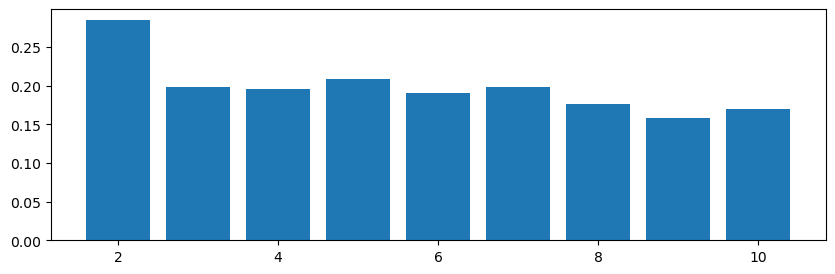

In [11]:
def determine_number_of_cluster(array):
    km_cost = []  # Sum of squared distances of samples to their closest cluster center.
    distortions = []  # the average of the squared distances from the cluster centers of the respective clusters.Typically, the Euclidean distance metric is used.
    km_silhouette = {}

    for i in range(2, 11):
        KM = KMeans(n_clusters=i, max_iter=999, n_init = 99, random_state=17)
        KM.fit(array)

        # Calculate Silhouette Scores
        preds = KM.predict(array)
        silhouette = silhouette_score(array, preds)
        km_silhouette[i] = silhouette

    print(max(km_silhouette, key=km_silhouette.get))
        
    return km_silhouette


def kmeans_cluster(array, num_of_cluster):
    kmeans = KMeans(n_clusters=num_of_cluster, max_iter=999, n_init = 99, random_state=17)
    kmeans.fit(array)
    y_kmeans = kmeans.predict(array)
    
    cluster_df = pd.DataFrame({'cluster': y_kmeans}, index=array.index)
    cluster_df['cluster'] = cluster_df['cluster'].astype(str)
    
    return cluster_df


# silhouette_scores = determine_number_of_cluster(mi_[plot_cols_mi])
silhouette_scores = determine_number_of_cluster(mi_[[f"Component_{v+1}" for v in range(0, pca_n)]])
print({idx: round(val, 4) for idx, val in silhouette_scores.items()})

# We select the second highest silhouette coefficient as the highest silhouette coefficient indicates only 2 groups. 
mi_copy = kmeans_cluster(mi_[[f"Component_{v+1}" for v in range(0, pca_n)]], 5)
mi_dams['cluster'] = mi_copy['cluster']
mi_dams.replace({'cluster': {'1': 'A', '2': 'B', '0': 'C', '4': 'D', '3': 'E'}}, inplace=True)

fig, ax = plt.subplots(figsize=(10,3))
ax.bar(silhouette_scores.keys(), silhouette_scores.values())

## Plot K-Means Results; SVI-related census data per cluster

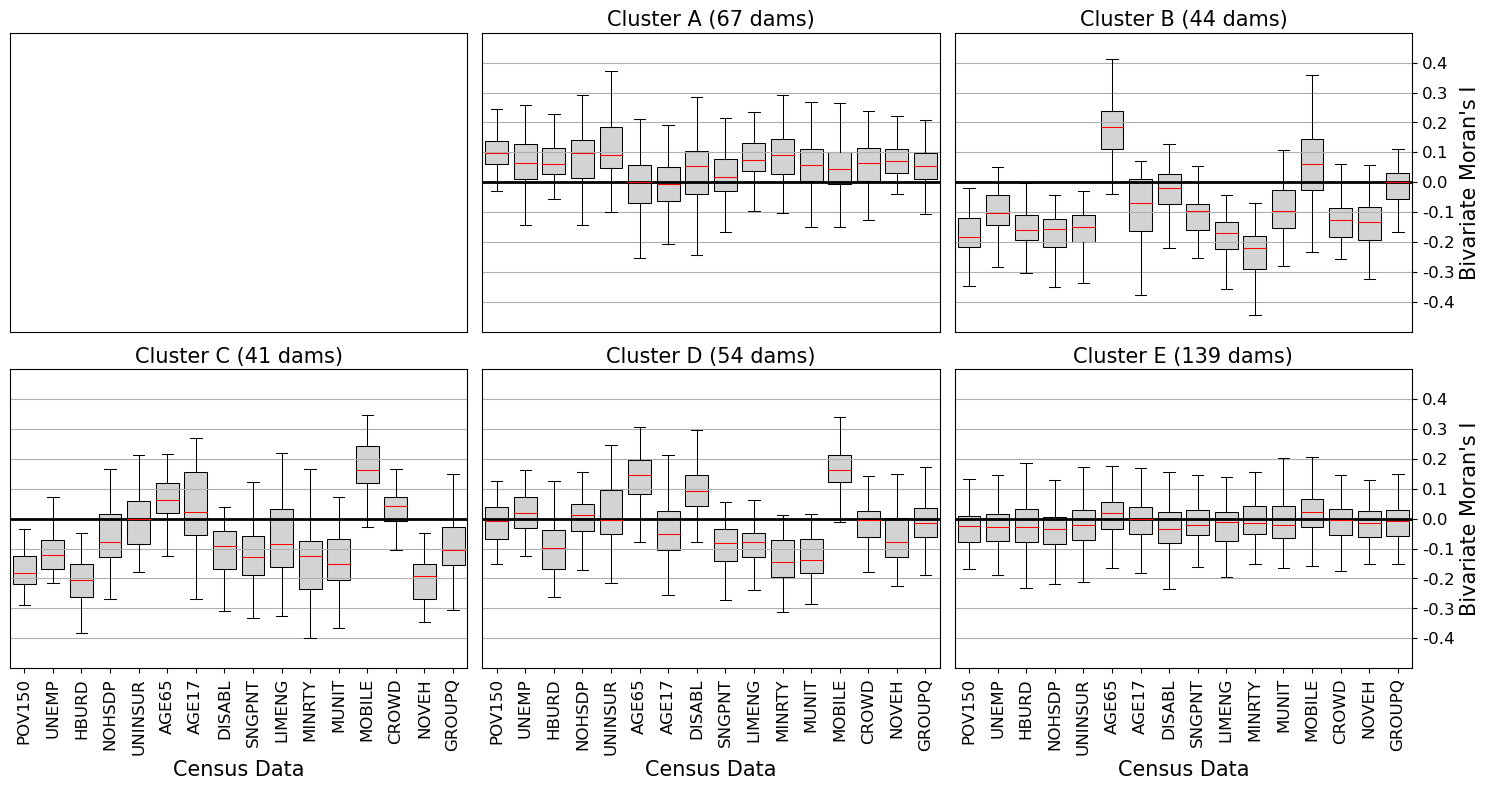

In [12]:
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.reshape(-1)

# Class A: Overall Disadvantaged Pop(except for uninsurance & age 17) - Red
# Class B: Overall Advantaged Pop(Except for Mobile home & Elderly) - Blue
# Class C: Partially Advantaged (Poverty, Unemployment, Houseburden, Single Parent, 
#                                Enlgihsh, Minority, MultiUnit, NoVehicle) - Lightblue
# Class D: Mixed Pattern - High Elderly & Disability & Mobile && Low Houseborden, Minority, English - Lightgreen
# Class E: No Major Pattern - Grey

PROPS = {'boxprops':{'facecolor':'#d3d3d3', 'edgecolor':'black'},
         'medianprops':{'color':'red'},
         'whiskerprops':{'color':'black'},
         'capprops':{'color':'black'}
        }

for idx, c in enumerate(['A', 'B', 'C', 'D', 'E'], start=1):

    temp_cluster = mi_dams.loc[mi_dams['cluster'] == c, 
                               [col for col in mi_dams.columns if col.startswith('MI')]
                              ].melt()
    sns.boxplot(x = 'variable', y = 'value', data=temp_cluster, ax=axes[idx], showfliers=False, linewidth=0.75, **PROPS)

    axes[idx].set_ylim(-0.5, 0.5)
    axes[idx].set_yticks([v / 10 for v in range(-4, 5, 1)])
    axes[idx].set_yticklabels([f"{v / 10}" for v in range(-4, 5, 1)], fontsize=12)
    axes[idx].text(0.5, 1.01, f'Cluster {c} ({round(temp_cluster.shape[0]/16)} dams)', 
                 ha = 'center', va = 'bottom', fontsize=15, transform=axes[idx].transAxes)
    axes[idx].axhline(0, color='black', linewidth=2)
    axes[idx].yaxis.grid(True)
#     axes[c].xaxis.grid(True)
    
    if (c == 'B') | (c == 'E'):
        axes[idx].set_ylabel("Bivariate Moran's I", fontsize=15)
        axes[idx].yaxis.set_label_position("right")
        axes[idx].yaxis.tick_right()
    else:
        axes[idx].yaxis.set_tick_params(labelleft=False, left=False)
        axes[idx].set_ylabel('')
    
    if (c == 'C') | (c == 'D') | (c == 'E'):
        axes[idx].set_xlabel("Census Data", fontsize=15)
        axes[idx].set_xticklabels([col.split('_')[1] for col in mi_.columns if col.startswith('MI')], 
                            rotation = 'vertical', fontsize=12)
    else:
        axes[idx].set_xlabel('')
        axes[idx].get_xaxis().set_visible(False)

axes[0].get_xaxis().set_visible(False)
axes[0].get_yaxis().set_visible(False)

plt.tight_layout()
plt.show()

<Axes: ylabel='count'>

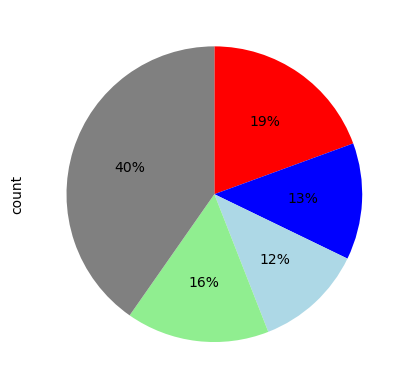

In [13]:
temp_df = pd.DataFrame({'cluster': ['A', 'B', 'C', 'D', 'E'], 'count': [67, 44, 41, 54, 139]})

temp_df['count'].plot.pie(colors=["red", "blue", 'lightblue', 'lightgreen', 'grey'], 
                 radius = 1 , 
                 startangle=90, counterclock=False, 
                 labels=None,
                          autopct=lambda p: '{:.0f}%'.format(round(p)) if p > 0 else ''
                )

Pacific Northwest Region 17 26
Missouri Region 10 42
Upper Mississippi Region 07 16
Ohio Region 05 74
Mid Atlantic Region 02 17
California Region 18 16
Arkansas-White-Red Region 11 50
Texas-Gulf Region 12 22
Lower Mississippi Region 08 13
South Atlantic-Gulf Region 03 26
New England Region 01 28


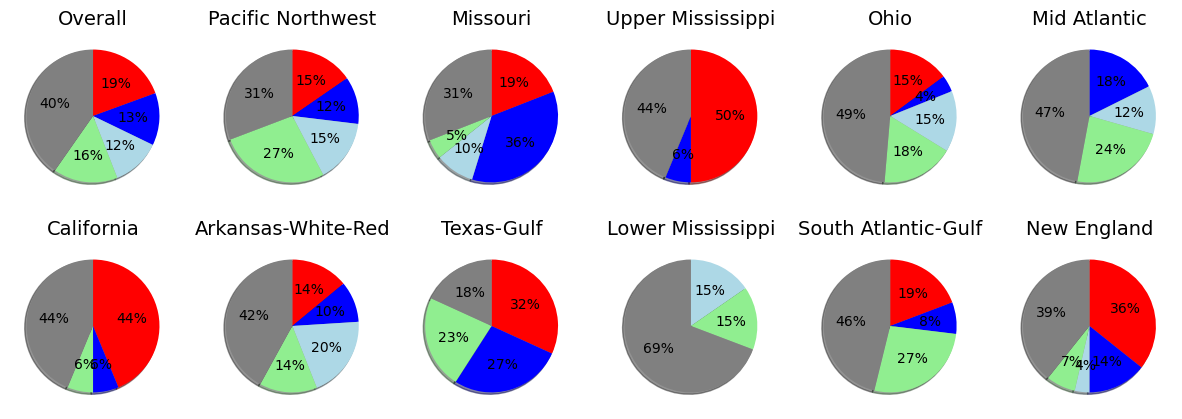

In [14]:
huc2_regions = ['Pacific Northwest Region', 'Missouri Region', 'Upper Mississippi Region', 
                'Ohio Region', 'Mid Atlantic Region', 'California Region', 
                'Arkansas-White-Red Region', 'Texas-Gulf Region', 'Lower Mississippi Region', 
                'South Atlantic-Gulf Region', 'New England Region']

fig, axes = plt.subplots(2, 6, figsize=(15, 5))
axes = axes.reshape(-1)

for idx, huc2_region in enumerate(huc2_regions, start=1):
    huc2 = basins.loc[basins['name'] == huc2_region, 'huc2'].values[0]
    huc2_mi = mi_dams.loc[mi_dams['HUC2'] == huc2]
    print(huc2_region, huc2, huc2_mi.shape[0])
    
    if huc2_mi.shape[0] > 5:
        cluster_count = huc2_mi.groupby('cluster').count()
        
        for cluster in ['A', 'B', 'C', 'D', 'E']:
            if not cluster in cluster_count.index:
                temp_df = pd.DataFrame({'cluster': [cluster], 'ID': [0]})
                temp_df = temp_df.set_index('cluster')
                cluster_count = pd.concat([temp_df, cluster_count])
        
        cluster_count['count'] = cluster_count['ID']
        cluster_count = cluster_count[['count']].reset_index()

        cluster_count['percent'] = cluster_count['count'] / cluster_count['count'].sum()
        cluster_count.sort_values('cluster', inplace=True)
        cluster_count.reset_index(drop=True, inplace=True)
        
        cluster_count['percent'].plot.pie(colors=["red", "blue", 'lightblue', 'lightgreen', 'grey'], 
                                          startangle=90,counterclock=False, 
                                          ax=axes[idx], shadow=True, labels=None, 
                                          autopct=lambda p: '{:.0f}%'.format(round(p)) if p > 0 else '', 
                                         )
        
        axes[idx].set_title(' '.join(huc2_region.split(' ')[:-1]), fontsize=14)
        axes[idx].get_xaxis().set_visible(False)
        axes[idx].get_yaxis().set_visible(False)


        
temp_df = pd.DataFrame({'cluster': ['A', 'B', 'C', 'D', 'E'], 'count': [67, 44, 41, 54, 139]})
temp_df['count'].plot.pie(colors=["red", "blue", 'lightblue', 'lightgreen', 'grey'], 
                 radius = 1 , 
                 startangle=90, counterclock=False, 
                 labels=None, ax=axes[0], shadow=True, 
                 autopct=lambda p: '{:.0f}%'.format(round(p)) if p > 0 else ''
                )
axes[0].set_title('Overall', fontsize=14)        
axes[0].get_xaxis().set_visible(False)
axes[0].get_yaxis().set_visible(False)
        
plt.show()
        

In [15]:
for idx, row in basins.iterrows():
    scount = mi.loc[mi['geometry'].within(row['geometry'])].shape[0]
    print(row['name'], scount)

South Atlantic-Gulf Region 26
Lower Mississippi Region 13
Tennessee Region 0
Ohio Region 74
Mid Atlantic Region 17
Upper Mississippi Region 16
New England Region 28
Great Lakes Region 2
Texas-Gulf Region 22
Rio Grande Region 4
Lower Colorado Region 3
Arkansas-White-Red Region 50
California Region 16
Great Basin Region 1
Upper Colorado Region 0
Missouri Region 42
Pacific Northwest Region 26
Souris-Red-Rainy Region 5


## Geographical locations 

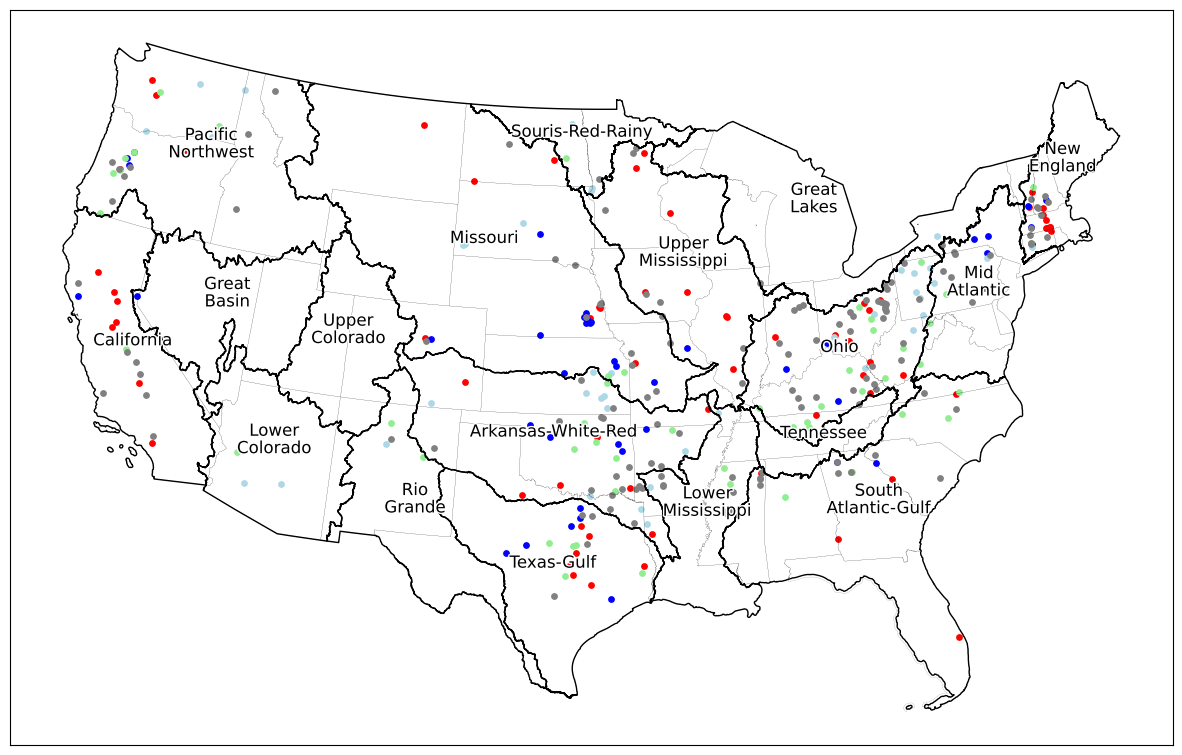

In [16]:
# mi_plot = pd.concat([mi, mi_[['cluster']]], axis=1)
mi_plot = mi_dams.copy(deep=True)
mi_plot = mi_plot.to_crs(epsg=5070)
mi_plot['cluster'] = mi_plot['cluster'].astype(str)

basins = basins.to_crs(epsg=5070)
states = states.to_crs(epsg=5070)

# Class A: Overall Disadvantaged Pop(except for uninsurance & age 17) - Red
# Class B: Overall Advantaged Pop(Except for Mobile home & Elderly) - Blue
# Class C: Partially Advantaged (Poverty, Unemployment, Houseburden, Single Parent, 
#                                Enlgihsh, Minority, MultiUnit, NoVehicle) - Lightblue
# Class D: Mixed Pattern - High Elderly & Disability & Mobile && Low Houseburden, Minority, English - Lightgreen
# Class E: No Major Pattern - Grey
fig, ax = plt.subplots(figsize=(15,15))
basins.boundary.plot(ax=ax, color='black', linewidth=1)
states.boundary.plot(ax=ax, color='black', linewidth=0.1, linestyle='dashed')
basins.apply(lambda x: ax.annotate(text='\n'.join(x['name'].split(' ')[:-1]), 
                                   size=12, 
                                   xy=x.geometry.centroid.coords[0], 
                                   ha='center',
                                   path_effects=[pe.withStroke(linewidth=2, foreground="white")]
                                  ),
             axis=1)

mi_plot.loc[mi_plot['cluster'] == 'A'].plot(ax=ax, color='red', markersize=15)    # Positive correlation; Disadvantaged population
mi_plot.loc[mi_plot['cluster'] == 'B'].plot(ax=ax, color='blue', markersize=15) # Mixture
mi_plot.loc[mi_plot['cluster'] == 'C'].plot(ax=ax, color='lightblue', markersize=15)   # Negative correlation; Advantaged population
mi_plot.loc[mi_plot['cluster'] == 'D'].plot(ax=ax, color='lightgreen', markersize=15)   # No correlation
mi_plot.loc[mi_plot['cluster'] == 'E'].plot(ax=ax, color='grey', markersize=15)   # No correlation

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

### Relationship with Year-bulit

In [17]:
mi_plot['Year Completed'] = mi_plot['Year Completed'].astype(int)
mi_plot.loc[mi_plot['Year Completed'] <= 1950, 'Year_JP'] = 'Older than 70 Years'
mi_plot.loc[(mi_plot['Year Completed'] > 1950) & (mi_plot['Year Completed'] <= 1970), 'Year_JP'] = '50 to 70 Years'
mi_plot.loc[mi_plot['Year Completed'] > 1970, 'Year_JP'] = 'Younger than 50 Years'

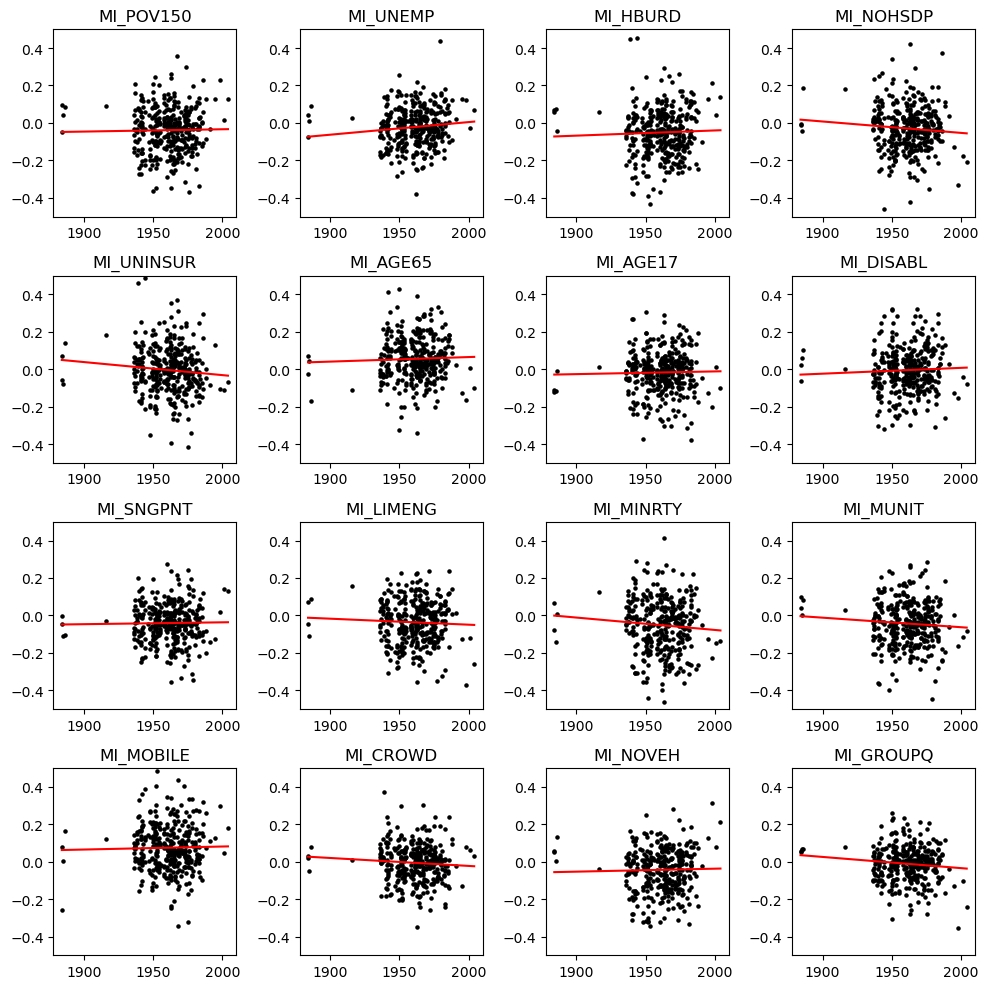

In [39]:
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
axes = axes.reshape(-1)

for idx, ax in enumerate(axes):
    # defining the variables
    x = mi_plot['Year Completed'].tolist()
    y = mi_plot[plot_cols_mi[idx]].tolist()

    # adding the constant term
    x = sm.add_constant(x)

    # performing the regression
    # and fitting the model
    result = sm.OLS(y, x).fit()

    alpha = result.params[1]
    b = result.params[0]
    x_ = np.linspace(mi_plot['Year Completed'].min(), mi_plot['Year Completed'].max(), 300)
    y_ = alpha * x_ + b
    
    axes[idx].scatter(mi_plot['Year Completed'], mi_plot[plot_cols_mi[idx]], s=5, color='black')
    axes[idx].plot(x_, y_, '-r')
    axes[idx].set_title(plot_cols_mi[idx])
    axes[idx].set_ylim(-0.5, 0.5)
    
    
    
    
plt.tight_layout()

In [19]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [22]:
mi_plot['Risk_JP'] = mi_plot.apply(lambda x:x['Risk'].split('(')[1].split(')')[0], axis=1)
mi_plot['Risk_JP'] = mi_plot['Risk_JP'].astype(int)
mi_plot

,ID,LAT,LON,NAME,LIBRARY_ID,LIBRARY_TYPE,MH_F,IH_F,TAS_F,SS_F,...,NID Height Category,Year Completed,Year Completed Category,Max Storage (Acre-Ft),Normal Storage (Acre-Ft),Hazard Potential Classification,HUC2,cluster,Year_JP,Risk_JP
0,CA10114,36.416309,-119.003224,TERMINUS DAM,199,dam_study,True,False,True,True,...,Greater than 100 feet,1962,1960-1969,235205.0,113431.0,High,18,E,50 to 70 Years,4
1,CA10113,36.060671,-118.919340,Richard L. Schafer Dam,98,dam_study,True,False,True,True,...,Greater than 100 feet,1961,1960-1969,230000.0,65473.0,High,18,A,50 to 70 Years,3
2,NY00468,42.733294,-77.907232,MOUNT MORRIS DAM,316,dam_study,True,False,True,True,...,Greater than 100 feet,1952,1950-1959,408000.0,4660.0,High,04,C,50 to 70 Years,4
3,CA10109,38.151041,-120.813699,NEW HOGAN DAM,297,dam_study,True,False,True,True,...,Greater than 100 feet,1963,1960-1969,348598.0,217410.0,High,18,A,50 to 70 Years,3
4,CA10104,37.906801,-120.934059,FARMINGTON DAM,260,dam_study,True,False,True,True,...,51-100 feet,1951,1950-1959,119314.0,6623.0,High,18,A,50 to 70 Years,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
340,MN00574,46.217141,-96.179236,ORWELL DAM,6188,dam_study,True,True,True,True,...,51-100 feet,1953,1950-1959,20600.0,8050.0,High,09,E,50 to 70 Years,4
341,IL00117,38.037328,-88.961679,REND DAM,6106,dam_study,True,True,True,True,...,51-100 feet,1971,1970-1979,607910.0,184675.0,High,07,E,Younger than 50 Years,4
342,OK10318,36.549055,-99.560571,FORT SUPPLY DAM,4203,dam_study,True,False,True,True,...,51-100 feet,1942,1940-1949,100700.0,13900.0,High,11,B,Older than 70 Years,3
343,MS01494,33.821629,-89.772394,GRENADA DAM,5646,dam_study,True,True,True,True,...,Greater than 100 feet,1954,1950-1959,2722100.0,85700.0,High,08,E,50 to 70 Years,4


In [27]:
tdf = pd.DataFrame(index=list(range(1, 6)), columns=['A', 'B', 'C', 'D', 'E'])
for idx in range(1, 6):
    for cls in ['A', 'B', 'C', 'D', 'E']:
        t_count = mi_plot.loc[(mi_plot['Risk_JP'] == idx) & (mi_plot['cluster'] == cls)].shape[0]
        tdf.loc[idx, cls] = t_count # round(t_count / 345, 3)
tdf

,A,B,C,D,E
1,0,1,1,0,1
2,7,4,3,5,8
3,18,11,6,19,38
4,35,23,25,24,76
5,7,5,6,3,16


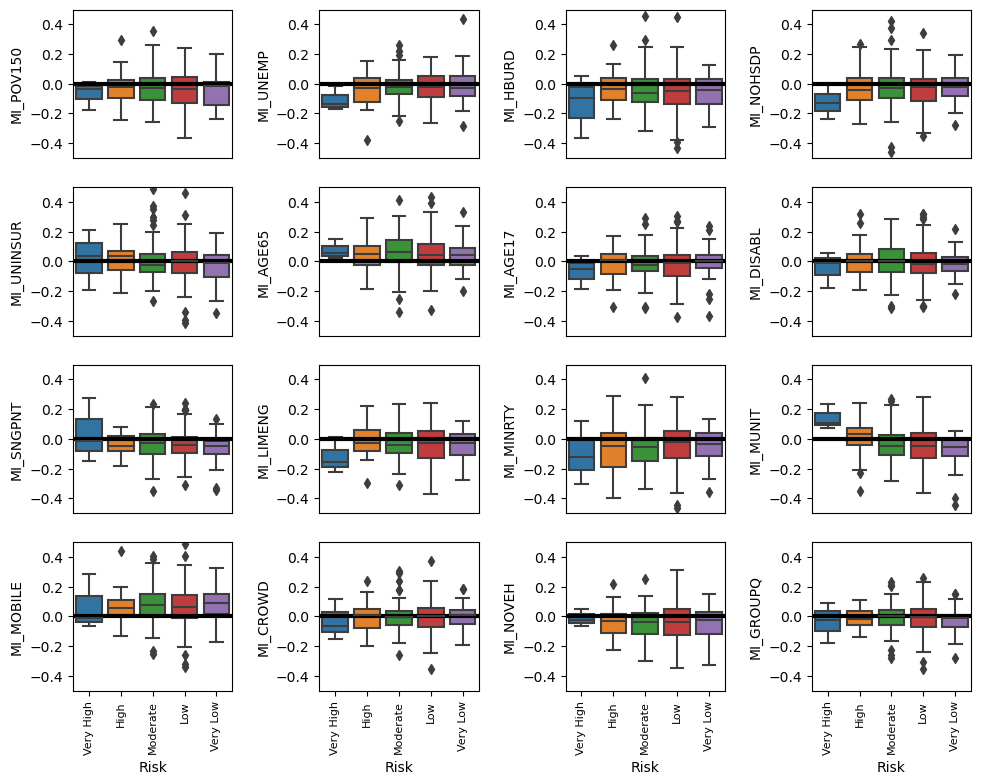

In [33]:
fig, axes = plt.subplots(4, 4, figsize=(10, 8))
axes = axes.reshape(-1)

for idx, ax in enumerate(axes):
    sns.boxplot(mi_plot, x='Risk', y=plot_cols_mi[idx], ax=axes[idx], 
                order=['Very High (1)', 'High (2)', 'Moderate (3)', 'Low (4)', 'Very Low (5)'] 
               )
    axes[idx].set_xticklabels(['Very High', 'High', 'Moderate', 'Low', 'Very Low'], fontsize=8, rotation=90)
    axes[idx].axhline(0, color='black', linewidth=3)
    axes[idx].set_ylim(-0.5, 0.5)
    
    if idx < 12:
        axes[idx].get_xaxis().set_visible(False)
    
plt.tight_layout()

### Dam Height

In [34]:
mi_plot['NID_Height_Category'] = mi_plot['NID Height Category']

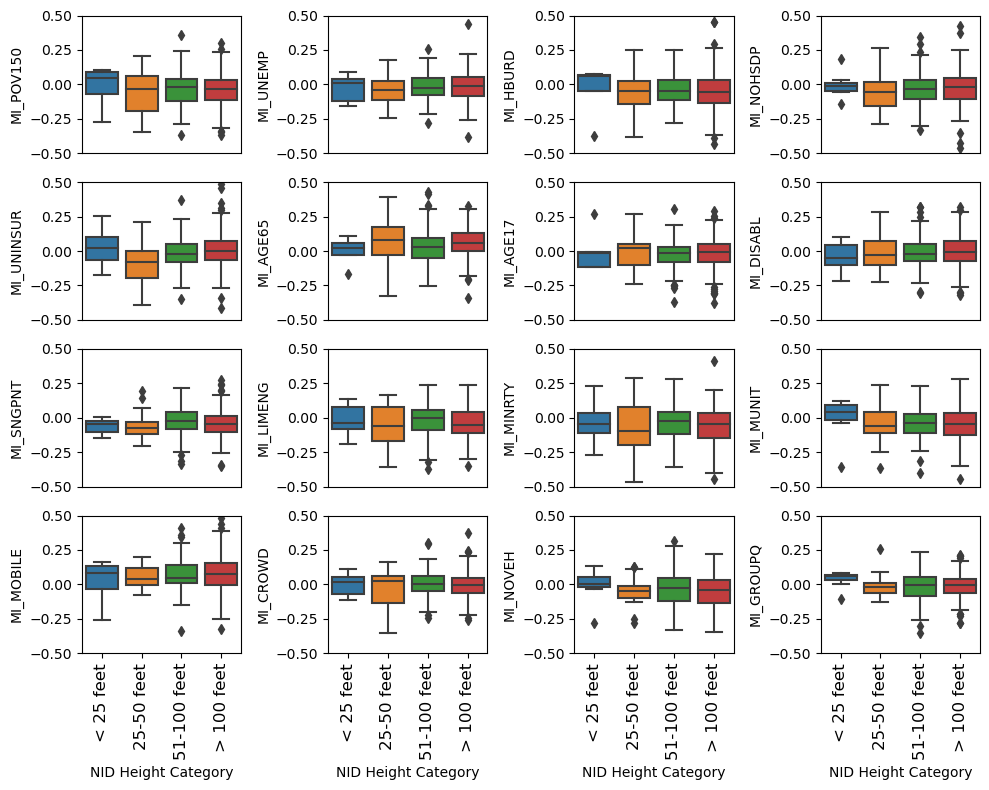

In [36]:
fig, axes = plt.subplots(4, 4, figsize=(10, 8))
axes = axes.reshape(-1)

for idx, ax in enumerate(axes):

    sns.boxplot(mi_plot, x='NID Height Category', y=plot_cols_mi[idx], ax=axes[idx], 
                order=['Less than 25 feet', '25-50 feet', '51-100 feet', 'Greater than 100 feet']
               )
    axes[idx].set_xticklabels(['< 25 feet', '25-50 feet', '51-100 feet', '> 100 feet'], rotation = 'vertical', fontsize=12)
#     axes[idx].set_xticklabels(['Before 1900', '1910-1919', '1930-1939', '1940-1949', '1950-1959', '1960-1969', '1970-1979', '1980-1989', '1990-1999', 'Since 2000'], rotation = 'vertical', fontsize=12)
    axes[idx].set_ylim(-0.5, 0.5)
    if idx < 12:
        axes[idx].get_xaxis().set_visible(False)
plt.tight_layout()

In [41]:
mi_plot[plot_cols_mi]

,MI_POV150,MI_UNEMP,MI_HBURD,MI_NOHSDP,MI_UNINSUR,MI_AGE65,MI_AGE17,MI_DISABL,MI_SNGPNT,MI_LIMENG,MI_MINRTY,MI_MUNIT,MI_MOBILE,MI_CROWD,MI_NOVEH,MI_GROUPQ
0,0.017772,-0.099167,0.111582,-0.109785,-0.178308,-0.013277,0.004232,0.020947,0.013254,-0.167206,-0.001590,0.074528,-0.068617,0.020064,0.073653,-0.007337
1,0.155147,0.163325,0.229622,-0.055764,-0.157273,0.096890,-0.125683,-0.132328,0.014848,0.129096,-0.009721,0.106022,0.071188,-0.028229,0.027247,0.202736
2,-0.181884,-0.151604,-0.194586,-0.201652,-0.083327,0.146950,0.046804,-0.247930,-0.187883,-0.196340,-0.264048,-0.245603,0.244990,-0.043612,-0.298288,0.160329
3,0.259143,0.135680,0.292829,0.192453,0.103470,-0.206889,0.251088,0.025816,0.237717,0.180437,0.411540,0.171349,-0.249586,0.177079,0.138698,-0.103665
4,0.096451,-0.012027,-0.048638,0.235570,0.190141,-0.254621,0.119883,-0.089960,-0.122915,0.130200,0.230624,-0.151156,0.010738,0.294876,-0.025660,0.233038
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
340,0.089522,0.041687,0.071678,-0.002201,-0.109035,0.098076,-0.110797,0.049854,0.008170,0.085857,-0.055161,-0.000515,-0.041789,0.044651,0.044993,0.116987
341,-0.064093,-0.040730,-0.083366,-0.042582,0.104623,0.081523,0.108361,-0.090647,0.075966,0.020753,0.034032,-0.038944,0.045011,0.001149,-0.060279,-0.075143
342,-0.205656,-0.104556,-0.241421,-0.248494,-0.151331,0.413720,-0.068682,0.246862,-0.226244,-0.309357,-0.307990,-0.244820,0.359618,-0.045632,-0.196567,-0.165583
343,0.027125,0.069448,0.025589,-0.166302,0.022552,-0.111240,0.048369,-0.259167,0.060161,-0.022016,0.054524,-0.023413,-0.053687,-0.103615,0.025335,-0.025329


<Axes: >

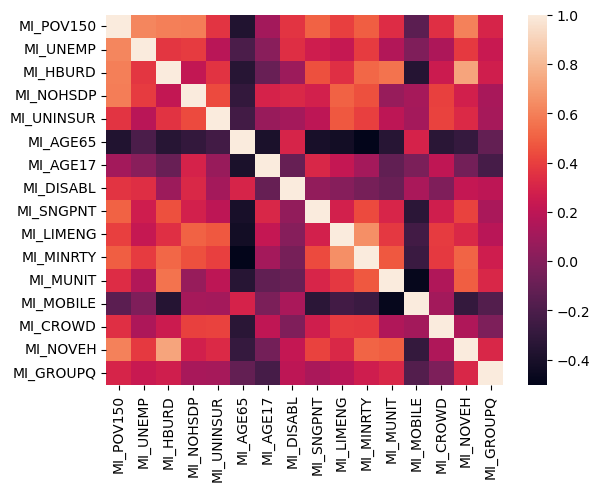

In [43]:
sns.heatmap(mi_plot[plot_cols_mi].corr())

# Done